In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'AppleGothic'
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

#평균온도(℃), 강수량(mm), 일사량(MJ/m2), 순간최대풍속(m/s), 습도(%)

In [2]:
df = pd.read_csv('./Downloads/BigDataPjtData/weather_final.csv')
df.head()

,년,월,평균온도,강수량,일사량,순간최대풍속,습도
0,2016,1,-1.23,198.10,209.30,15.40,68.94
1,2016,2,1.37,309.42,285.32,15.17,64.30
2,2016,3,6.56,348.70,446.80,13.45,63.29
3,2016,4,13.46,1074.22,456.60,19.61,68.10
4,2016,5,18.32,768.40,561.43,17.65,68.58


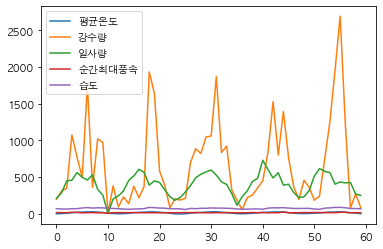

In [3]:
df.iloc[:, 2:].plot();

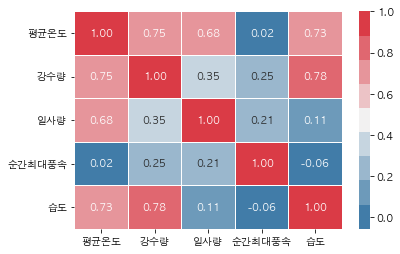

In [4]:
#기후피처들 끼리의 상관성
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.diverging_palette(240, 10, n=9)
sns.heatmap(df.iloc[:,2:].corr(), annot=True, cmap=cmap, linewidths=0.5, fmt='.2f');

In [5]:
# #다중공선성 => VIF가 10보다 크면 문제가 있다고 판단
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# df_reg = df[['평균온도','강수량','일사량','순간최대풍속','습도']]
# df_vif = pd.DataFrame()
# df_vif['VIF'] = np.round([variance_inflation_factor(df_reg.values,i) for i in range(df_reg.shape[1])],2)
# df_vif['features'] = df_reg.columns
# df_vif.sort_values(by='VIF', ascending=False)

- 서로 상관성이 높은 피처들이 몇 개 있다(평균온도, 강수량, 습도)
- 하지만 완벽하게 같지는 않아서 피처 모두를 소매가격 분석에 사용

In [6]:
price = pd.read_csv('./Downloads/BigDataPjtData/FullPrice_final.csv')
price.head()

,년,월,상품소매가격,중품소매가격,전체소매가격
0,2016,1월,4064,4064,4064
1,2016,2월,4091,4091,4091
2,2016,3월,4409,4409,4409
3,2016,4월,4362,4362,4362
4,2016,5월,4597,4597,4597


In [7]:
#연평균 해 삭제
a = price[price['월']=='연평균'].index
price = price.drop(a, axis=0)

In [8]:
#2021년 삭제
b = price.iloc[-12:,:].index
price = price.drop(b, axis=0).reset_index(drop=True)

In [9]:
#price, df 합치기 위해 index 생성
price = price.reset_index()
df = df.reset_index()

In [10]:
#price, df 합치기
df1 = pd.merge(price, df, on='index')
df1 = df1.drop(['년_y', '월_y', 'index'], axis=1)

c = df1['년_x'].astype(str) + '-' + df1['월_x'].str[:-1]
df1.insert(0, '날짜', c)

df1 = df1.drop(['년_x', '월_x'], axis=1)

df1.tail()

,날짜,상품소매가격,중품소매가격,전체소매가격,평균온도,강수량,일사량,순간최대풍속,습도
55,2020-8,7891,7891,7891,26.40,2692.52,433.48,19.58,86.75
56,2020-9,6391,6391,6391,20.32,1229.97,419.65,19.24,81.24
57,2020-10,5707,5707,5707,13.72,76.72,425.55,12.71,70.97
58,2020-11,5678,5678,5678,8.51,272.02,268.61,14.86,69.95
59,2020-12,5797,5797,5797,0.34,79.28,249.46,13.84,66.98


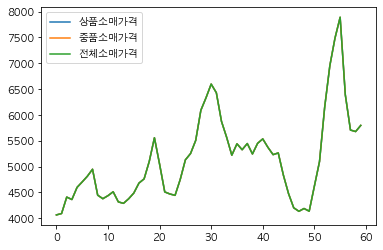

In [11]:
#상품, 중품, 전체 소매가격간의 상관관계(1)
df1.iloc[:, 0:4].plot();

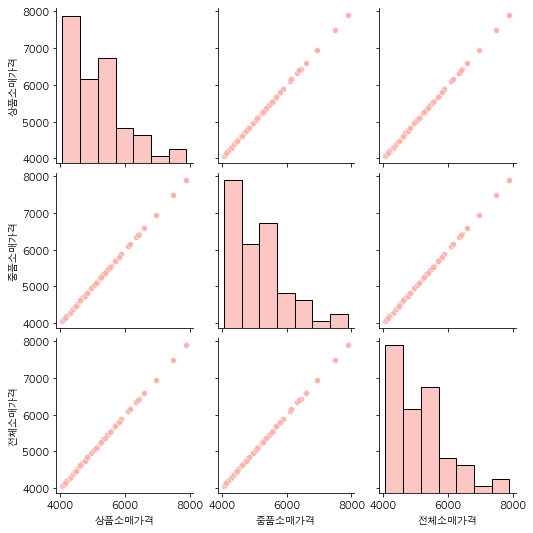

In [12]:
#상품, 중품, 전체 소매가격간의 상관관계(2)
sns.set_palette('Pastel1')
sns.pairplot(df1.iloc[:, 0:4]);

- 상품, 중품, 전체 소매가격은 서로 깊은 상관관계를 가지고 있으므로, 전체소매가격을 대표로 해서 다른 피쳐들과 비교

In [13]:
df2 = df1.iloc[:,3:]
df2.tail()

,전체소매가격,평균온도,강수량,일사량,순간최대풍속,습도
55,7891,26.40,2692.52,433.48,19.58,86.75
56,6391,20.32,1229.97,419.65,19.24,81.24
57,5707,13.72,76.72,425.55,12.71,70.97
58,5678,8.51,272.02,268.61,14.86,69.95
59,5797,0.34,79.28,249.46,13.84,66.98


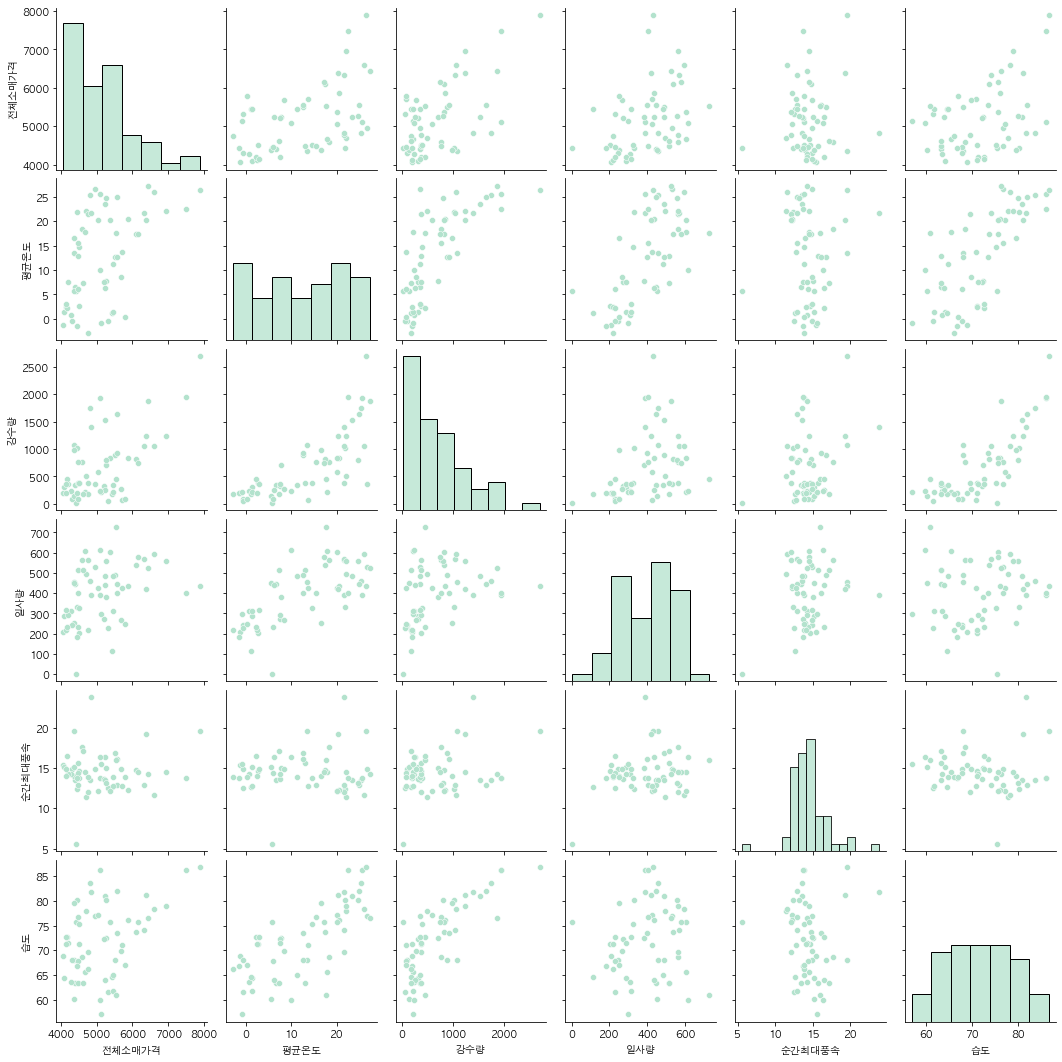

In [14]:
#전체소매가격과 전체 피처들 간의 상관관계 시각화
sns.set_palette('Pastel2')
sns.pairplot(df2);

- 시각적으로 볼 때 전체소매가격과 순간최대풍속과는 관련이 없어보인다
- '순간최대풍속' 기각

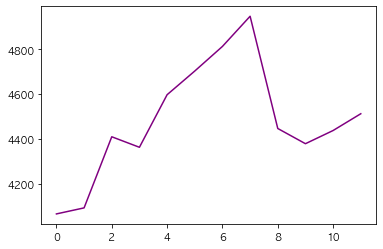

In [15]:
#이상치 제거 -> 정규화 -> 관련성 검정
#월에 따른 고구마 소매가격
df2.iloc[:12,:]['전체소매가격'].plot(color='purple');

In [16]:
df_16 = df1.iloc[:12,:]
df_17 = df1.iloc[12:24,:]
df_18 = df1.iloc[24:36,:]
df_19 = df1.iloc[36:48,:]
df_20 = df1.iloc[48:60,:]

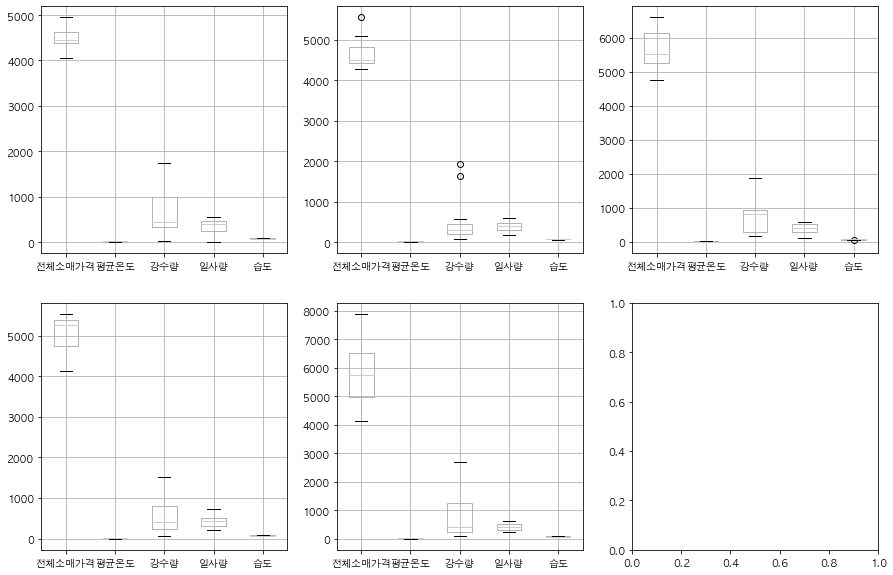

In [17]:
#이상치 확인
# 품종별 가격 평균 이상치 탐색
# plt.figure(figsize=(15,10))
# sns.jointplot(x=auction['연도'], y=auction['가격(kg)'], hue=auction['품종'], )
# plt.show()

f, ax = plt.subplots(2, 3, figsize=(15, 10))

df_16.boxplot(column=['전체소매가격','평균온도','강수량','일사량','습도'], ax = ax[0,0]);
df_17.boxplot(column=['전체소매가격','평균온도','강수량','일사량','습도'], ax = ax[0,1]);
df_18.boxplot(column=['전체소매가격','평균온도','강수량','일사량','습도'], ax = ax[0,2]);
df_19.boxplot(column=['전체소매가격','평균온도','강수량','일사량','습도'], ax = ax[1,0]);
df_20.boxplot(column=['전체소매가격','평균온도','강수량','일사량','습도'], ax = ax[1,1]);

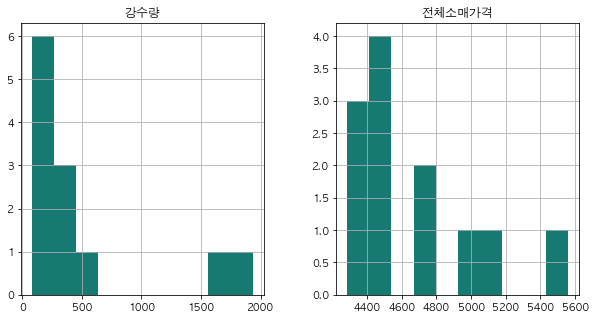

In [18]:
#2017년도 전체소매가격, 강수량 이상치 제거
#이상치 제거 전후를 비교하기 위한 그래프
sns.set_palette('BrBG_r')
original_df = df_17[['강수량','전체소매가격']]
original_df.hist(figsize=(10,5));

In [19]:
#Q1, Q3, IQR 정의하기
Q1 = df_17[['강수량','전체소매가격']].quantile(q=0.25)
Q3 = df_17[['강수량','전체소매가격']].quantile(q=0.75)
IQR = Q3-Q1

In [20]:
#이상치 데이터 제거하기
IQR_df = df_17[(df_17['강수량'] <= Q3['강수량']+1.5*IQR['강수량']) & (df_17['강수량'] >= Q1['강수량']-1.5*IQR['강수량'])]
IQR_df = IQR_df[(IQR_df['전체소매가격'] <= Q3['전체소매가격']+1.5*IQR['전체소매가격']) & (IQR_df['전체소매가격'] >= Q1['전체소매가격']-1.5*IQR['전체소매가격'])]

IQR_df = IQR_df[['강수량','전체소매가격']]

print('original_df :', len(original_df))
print('IQR_df :', len(IQR_df))

original_df : 12
IQR_df : 10


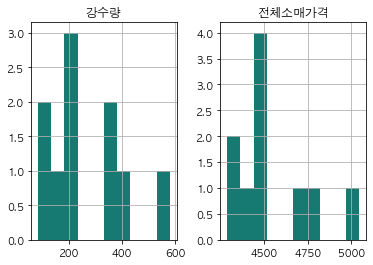

In [21]:
IQR_df.hist();

In [22]:
df_17['강수량'] = IQR_df['강수량']
df_17['전체소매가격'] = IQR_df['전체소매가격']
df_17 = df_17.dropna()

In [23]:
#정규성 검사
data = [df_16, df_17, df_18, df_19, df_20]
col = ['전체소매가격','평균온도','강수량','일사량','습도']
a = 0
b = 0
for i in data:
    a+=1
    for j in col:
        sta, pval = stats.shapiro(i[j])
        b = (b+1)%4
        if (pval < 0.05):
            #데이터가 정규분포를 따르지 않음
            print(a,b)

4 0
5 3


- df_19의 전체소매가격, df_20의 강수량이 정규분포를 따르지 않는다.

In [24]:
print(stats.shapiro(df_19['전체소매가격']))
print(stats.shapiro(df_20['강수량']))

ShapiroResult(statistic=0.8138327598571777, pvalue=0.013515905477106571)
ShapiroResult(statistic=0.8250711560249329, pvalue=0.018320750445127487)


In [25]:
#최대-최소 정규화 : (X - MIN) / (MAX-MIN) 
def min_max_normalize(lst):
    normalized=[]
    for value in lst:
        normalized_num = (value - min(lst)) / (max(lst) - min(lst))
        normalized.append(normalized_num)
    return normalized

#z-정규화
def z_score_normalize(lst):
    normalized=[]
    for value in lst:
        normalized_num = (value - np.mean(lst)) / np.std(lst)
        normalized.append(normalized_num)
    return normalized

In [26]:
print(stats.shapiro(min_max_normalize(df_19['전체소매가격'])))
print(stats.shapiro(min_max_normalize(df_20['강수량'])))

ShapiroResult(statistic=0.8138325810432434, pvalue=0.013515847735106945)
ShapiroResult(statistic=0.8250709176063538, pvalue=0.018320633098483086)


In [27]:
print(stats.shapiro(z_score_normalize(df_19['전체소매가격'])))
print(stats.shapiro(z_score_normalize(df_20['강수량'])))

ShapiroResult(statistic=0.8138327598571777, pvalue=0.013515905477106571)
ShapiroResult(statistic=0.8250711560249329, pvalue=0.018320750445127487)


In [28]:
print(stats.shapiro(np.log1p(df_19['전체소매가격'])))
print(stats.shapiro(np.log1p(df_20['강수량'])))

ShapiroResult(statistic=0.7999372482299805, pvalue=0.009353510104119778)
ShapiroResult(statistic=0.954670250415802, pvalue=0.705909252166748)


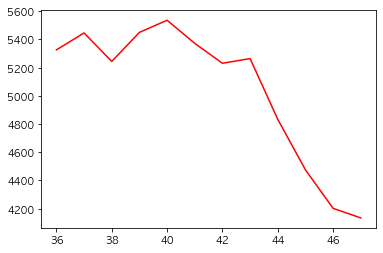

In [29]:
df_19['전체소매가격'].plot(color='red');

In [30]:
#df_19의 전체소매가격 데이터 로그 정규화
df_19['전체소매가격'] = np.log1p(df_19['전체소매가격'])

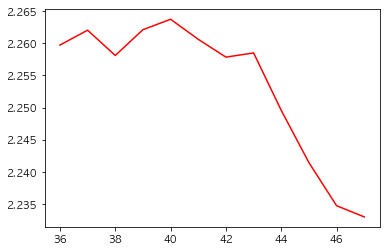

In [31]:
np.log1p(df_19['전체소매가격']).plot(color='red');

- df_19의 전체소매가격 데이터 로그 정규화했음에도 그래프 모양은 그다지 변하지 않았다.

- df_20의 강수량 데이터는 정규화되지 않았다

In [32]:
#2016년으로만 좁혀서 상관성 분석
from scipy import stats
#corr, pval
print(stats.pearsonr(df_16['전체소매가격'], df_16['평균온도']))
print(stats.pearsonr(df_16['전체소매가격'], df_16['강수량']))
print(stats.pearsonr(df_16['전체소매가격'], df_16['일사량']))
print(stats.pearsonr(df_16['전체소매가격'], df_16['습도']))

(0.8199379447771844, 0.0010923827678691322)
(0.33733714859217623, 0.28357732475531827)
(0.5476110107678029, 0.06532817892473217)
(0.5856513430560892, 0.04541186981247418)


In [33]:
#2017년으로만 좁혀서 상관성 분석
from scipy import stats
#corr, pval
print(stats.pearsonr(df_17['전체소매가격'], df_17['평균온도']))
print(stats.pearsonr(df_17['전체소매가격'], df_17['강수량']))
print(stats.pearsonr(df_17['전체소매가격'], df_17['일사량']))
print(stats.pearsonr(df_17['전체소매가격'], df_17['습도']))

(0.838226845665378, 0.002453041161994747)
(0.7733672401944142, 0.008689616029046077)
(0.5058745227913809, 0.13575557853302161)
(0.6541933986212177, 0.04015668720100042)


In [34]:
#2018년으로만 좁혀서 상관성 분석
from scipy import stats
#corr, pval
print(stats.pearsonr(df_18['전체소매가격'], df_18['평균온도']))
print(stats.pearsonr(df_18['전체소매가격'], df_18['강수량']))
print(stats.pearsonr(df_18['전체소매가격'], df_18['일사량']))
print(stats.pearsonr(df_18['전체소매가격'], df_18['습도']))

(0.9399450747414461, 5.559306380132698e-06)
(0.8023379128916382, 0.0016871933950782423)
(0.8189532066586729, 0.001120606533902105)
(0.7150522878958139, 0.008951376034111627)


In [35]:
#2019년으로만 좁혀서 상관성 분석
from scipy import stats
#corr, pval
print(stats.pearsonr(df_19['전체소매가격'], df_19['평균온도']))
print(stats.pearsonr(df_19['전체소매가격'], df_19['강수량']))
print(stats.pearsonr(df_19['전체소매가격'], df_19['일사량']))
print(stats.pearsonr(df_19['전체소매가격'], df_19['습도']))

(0.2064981576820528, 0.5196271267684146)
(0.03872505262983028, 0.9048903616103927)
(0.5808793541325629, 0.047637555088383174)
(-0.336254332603244, 0.28522360830742677)


In [36]:
#2020년으로만 좁혀서 상관성 분석
from scipy import stats
#corr, pval
print(stats.pearsonr(df_20['전체소매가격'], df_20['평균온도']))
print(stats.pearsonr(df_20['전체소매가격'], df_20['강수량']))
print(stats.pearsonr(df_20['전체소매가격'], df_20['일사량']))
print(stats.pearsonr(df_20['전체소매가격'], df_20['습도']))

(0.8756046369522918, 0.00018968712231391612)
(0.8256018005101858, 0.0009405181279351418)
(0.2634642311603686, 0.40801178232977486)
(0.7613385861993769, 0.00401909499489891)


- p-값 ≤ α: 상관 관계가 통계적으로 유의하다
- 2019년도 제외, 평균온도, 습도가 전체소매가격과 상관성이 있다
- 그 중에서도 평균온도가 높은 상관성을 보인다.

In [37]:
#연도별 평균온도, 평균소매가격간의 관계를 시각화
df16_v = pd.DataFrame(df_16.mean()[['전체소매가격', '평균온도']]).T
df17_v = pd.DataFrame(df_17.mean()[['전체소매가격', '평균온도']]).T
df18_v = pd.DataFrame(df_18.mean()[['전체소매가격', '평균온도']]).T
df19_v = pd.DataFrame(df_19.mean()[['전체소매가격', '평균온도']]).T
df20_v = pd.DataFrame(df_20.mean()[['전체소매가격', '평균온도']]).T

df_v = pd.concat([df16_v, df17_v, df18_v, df19_v, df20_v])
df_v['전체소매가격'] = df_v['전체소매가격'].round(0)
df_v['평균온도'] = df_v['평균온도'].round(2)
df_v

,전체소매가격,평균온도
0,4480.0,13.28
0,4538.0,9.78
0,5682.0,12.55
0,9.0,12.63
0,5841.0,12.84


In [57]:
#전체 연도의 평균온도, 습도와 소매가격간의 상관성
import statsmodels.api as sm
from statsmodels.formula.api import ols

results = ols('전체소매가격~평균온도+습도+강수량', data = df1).fit()
results.summary()

#R-squared : 결정계수, 1에 가까울수록 모델의 설명력이 높음
#Prob(F-satistic) : p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 전체소매가격   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     11.03
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           8.56e-06
Time:                        13:40:11   Log-Likelihood:                -475.37
No. Observations:                  60   AIC:                             958.7
Df Residuals:                      56   BIC:                             967.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6291.2479   1348.566      4.665      0.000    3589.745    8992.751
평균온도          19.4095     15.607      1.244      0.219     -11.855      50.674
습도           -27.6488     20.910     -1.322      0.191     -69.536      14.238
강수량            0.8952      0.271      3.307      0.002       0.353       1.438
==============================================================================
Omnibus:                        3.300   Durbin-Watson:                   0.447
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                2.139
Skew:                           0.255   Prob(JB):                        0.343
Kurtosis:                       2.229   Cond. No.                     1.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Prob(F-satistic) 값이 0.05보다 작기에 이 회귀식은 회귀분석 모델 전체에 대해 통계적으로 의미가 있다고 볼 수 있다.
- P>|t| 값이 0.05보다 작은 평균온도가 전체소매가격에 미치는 영향이 유의하다.

In [39]:
#연도별 전체소매가격과 평균온도 상관성
print(stats.pearsonr(df_16['전체소매가격'], df_16['평균온도']))
print(stats.pearsonr(df_17['전체소매가격'], df_17['평균온도']))
print(stats.pearsonr(df_18['전체소매가격'], df_18['평균온도']))
print(stats.pearsonr(df_19['전체소매가격'], df_19['평균온도']))
print(stats.pearsonr(df_20['전체소매가격'], df_20['평균온도']))

(0.8199379447771844, 0.0010923827678691322)
(0.838226845665378, 0.002453041161994747)
(0.9399450747414461, 5.559306380132698e-06)
(0.2064981576820528, 0.5196271267684146)
(0.8756046369522918, 0.00018968712231391612)


In [48]:
#연도별 전체소매가격과 강수량 상관성
print(stats.pearsonr(df_16['전체소매가격'], df_16['강수량']))
print(stats.pearsonr(df_17['전체소매가격'], df_17['강수량']))
print(stats.pearsonr(df_18['전체소매가격'], df_18['강수량']))
print(stats.pearsonr(df_19['전체소매가격'], df_19['강수량']))
print(stats.pearsonr(df_20['전체소매가격'], df_20['강수량']))

(0.33733714859217623, 0.28357732475531827)
(0.7733672401944142, 0.008689616029046077)
(0.8023379128916382, 0.0016871933950782423)
(0.03872505262983028, 0.9048903616103927)
(0.8256018005101858, 0.0009405181279351418)


In [49]:
#연도별 전체소매가격과 습도 상관성
print(stats.pearsonr(df_16['전체소매가격'], df_16['습도']))
print(stats.pearsonr(df_17['전체소매가격'], df_17['습도']))
print(stats.pearsonr(df_18['전체소매가격'], df_18['습도']))
print(stats.pearsonr(df_19['전체소매가격'], df_19['습도']))
print(stats.pearsonr(df_20['전체소매가격'], df_20['습도']))

(0.5856513430560892, 0.04541186981247418)
(0.6541933986212177, 0.04015668720100042)
(0.7150522878958139, 0.008951376034111627)
(-0.336254332603244, 0.28522360830742677)
(0.7613385861993769, 0.00401909499489891)


- 2019년도에 무슨일이?
- 농가에서는 고구마값 하락의 가장 큰 원인으로 생산면적 증가로 인한 과잉생산을 꼽았다.
- 지속적으로 고구마값이 상승해서 고구마 농사를 짓는 농가들이 전국적으로 많아졌다는 것이다. -기사

- 고구마 소매가격(상품, 중품, 전체)는 '평균온도', '강수량', '습도'와 관련성이 있다